<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-and-theory" data-toc-modified-id="Introduction-and-theory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction and theory</a></span></li><li><span><a href="#Developing-a-WCM-version-with-an-empirical-soil-model" data-toc-modified-id="Developing-a-WCM-version-with-an-empirical-soil-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Developing a WCM version with an empirical soil model</a></span><ul class="toc-item"><li><span><a href="#Some-further-remarks" data-toc-modified-id="Some-further-remarks-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Some further remarks</a></span></li></ul></li><li><span><a href="#Extracting-data" data-toc-modified-id="Extracting-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extracting data</a></span><ul class="toc-item"><li><span><a href="#Field-and-Sentinel-1-data" data-toc-modified-id="Field-and-Sentinel-1-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Field and Sentinel 1 data</a></span></li><li><span><a href="#The-Sentinel2-retrieved-parameters-from-KaSKA" data-toc-modified-id="The-Sentinel2-retrieved-parameters-from-KaSKA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The Sentinel2 retrieved parameters from KaSKA</a></span></li></ul></li></ul></div>

In [2]:
# Generic imports
from pathlib import Path
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import scipy.stats 

%matplotlib inline

from SAR_retrieval_funcs import cost_function, fwd_model
from SAR_retrieval_funcs import invert_field, do_plots, prepare_field_data



# Combined retrieval from S1 and S2

## Introduction and theory
Most forms of the water cloud model tend to ignore multiple scattering terms, and thus have two contributions:

1. a canopy scattering contribution and,
2. a soil contribution, attenuated by the two way canopy path.

The general expression is

$$
\sigma_{pp}^{0} = \frac{1}{2}\omega_{c}\cos\theta\left[1-\exp\left(-\frac{2BV_2}{\cos\theta}\right)\right] + \exp\left(-\frac{2BV_2}{\cos\theta}\right)\sigma_{soil}^{0}.
$$

where $\omega_c$ is the canopy scattering term, $V_2$ is the equivalent canopy optical depth, $\mu=\cos\theta$ is the cosine of the angle of incidence and $\sigma_{soil}^{0}$ is the soil backscattering coefficient. $B$ is an empirical constant that mostly relates to the extinction of radiation through the canopy, and usually, $\omega_c=A\cdot V_1$, or in other words, the canopy scattering term is just an empirical scaling of some vegetation optical depth.

## Developing a WCM version with an empirical soil model

We'll develop some expressions for a WCM model with a Jacobian, as we'll be seeking to fit the WCM to observations and infer parameters.

For completeness, the WCM definition is as follows:

$$
\sigma_{pq}^{0} = A_{pq}\cdot V_{1}\left[1 - \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\cdot\sigma_{soil}^{pq}.
$$

The previous definition assumes that the soil backscatter can be modelled as a function of something. In this case, we use the Oh 2004 model, which models soil backscatter for the VV, HH and HV polarisations as a function of volumetric soil moisture and a soil roughness term. Previous Oh versions of the model, and the Dubois models are also simple, but a bit more involved in their calculations. We'll take the Oh 2004 model, and have a poke around to see if we can get some insights.

The Oh model in essence can be written (for HV and VV polarisations) as a function of angle of incidence $\theta$, soil moisture $mv$ and wavenumber times rms roughness, $ks$:
$$
\begin{align}
\sigma_{HV} &= a\cdot b\\
\sigma_{VV} &= \frac{a\cdot b}{q}\\
q_0(\theta) &= 0.095\cdot\left(0.13 + \sin(1.5\theta)\right)^{1.4}\\
f_{q}(ks) &= (1 - \exp(-1.3 \cdot ks^{0.9}))\\
a &= 0.11\cdot mv^{0.7}  \cos(\theta)^{2.2}\\
b &= 1-\exp(-0.32\cdot ks^{1.8})\\
\end{align}
$$

If $\theta$ is identical for both polarisations, we have that
$$
\begin{align}
\sigma_{HV} &= f_{A}(\theta)\cdot mv^{0.7}\cdot f_{b}(ks)\\
\sigma_{VV} &= f_{A}(\theta)\cdot \frac{f_{b}(ks)}{q_{0}(\theta)\cdot f_{q}(ks)}\cdot mv^{0.7}
\end{align}
$$

The multiplicative model in linear units becomes an additive model in dB, suggesting that the Oh 2004 model can be inverted linearly. In this respect, we'd envisage the Oh 2004 model as a way of possibly obtaining prior parameter distributions. We note that the $ks$ parameter is a way of scaling up or down frequencies (as it represents a form of roughness scaled by wavelength). There's an intriguing concept if we can add some extra constraints on $ks$ to support retrieval within time series. 

These observations aren't extraordinary: a lot of approaches to soil moisture retrieval observe that changes in backscatter can directly be associated with soil moisture changes. Over small temporal windows, one can assume $ks$ constant, and thus use two or more observations to solve for $mv$. Most of the models do produce their own relationship, which are all slightly different to each other, and hard to compare as they often either use different geometric or polarimetric set-ups. However, all this body of literature suggests that this approach may be sufficient to model the soil.

Rewriting the model in dB scale, we have

$$
\begin{align}
\sigma_{hv} &= \log_{10}(fa_t) + \log_{10}(fb_k) + 0.7\cdot\log_{10}(mv) \\
\sigma_{vv} &= \left(\log_{10}(fa_t) - \log_{10}(q_{0})\right) \\
            &+ \left(\log_{10}(fb_k) - \log_{10}(fq_{k})\right) \\
            &+ 0.7*\log_{10}(mv) \\
\end{align}
$$

The first term on both equations is an angular term, whereas the second term is related to roughness. The third term is related to moisture. If we are not (initially) interested in roughness, we can just lump the roughness contributions into a polarisation-dependent parameter, e.g. $R_{pq}$, and we can then have a second, polarisation independent, moisture term $mv_{s}=0.7\log_{10}(mv)$. In other words, we can probably fit the soil model using a time series, particularly if we are willing to drop explainability of soil roughness (although this can be retrieved at a latter stage).

The above comments results in the complete WCM being:

$$
\sigma_{pq}^{0} = A_{pq}\cdot V_{1}\left[1 - \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\cdot\left[K_{pq} + R_{pq} + mv_{s} \right].
$$

It's a simple model to differentiate, and for completeness, here are the partial derivatives (I define a few common functions at the top).


$$
\begin{align*}
\sigma_{soil} &= K_{pq} + R_{pq} + mv_{s}\\
\mu &= \cos(\theta)\\
\tau &= \exp\left(-\frac{2B\cdot V_{2}}{\cos\theta}\right)\\
\frac{\partial \sigma_{pq}^{0}}{\partial A} &= V_{1} - V_{1}\tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial B} &= \frac{-2V_2}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\frac{\partial \sigma_{pq}^{0}}{\partial V_{1}} &= A - A\tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial V_{2}} &= \frac{-2B}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\frac{\partial \sigma_{pq}^{0}}{\partial mv_{s}} &= \tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial R_{pq}} &= \tau\\
\end{align*}
$$



The outshoot of this is that a retrieval strategy based on de-coupling angles, roughness and moisture is possible and not overly complicated. Under the assumption that roughness is slowly varying in time for the same location, we have a two or three parameter retrieval strategy (e.g. $mv,\,f_{B}(ks)$ and $f_{q}(ks)$). What's neat is that these parameters are **shared between polarisations**.


### Some further remarks

It is entirely possible to approximate the model above via a linear polynomial. The way to do this is to expand the first equation with a MacLaurin series. In order to deal with the non-linearity, you need some 3 to 4 terms, but this is dependent on the different model parameters. Left here as a footnote.

Another interesting thing is that the VV/VH ratio for bare soils should be insensitive to soil moisture. In the above formulation, we can see that the terms with $mv$ basically cancel out in the case of a polarisation ratio (this doesn't happen for VH/HH, as in RADARSAT, a combination that dampens the effect of $ks$ on $mv$).



## Extracting data

### Field and Sentinel 1 data

This is all coming from a CSV file. The next few blocks/cells do some first plotting of the data...

In [3]:
chunk = """;301;301;301;301;301;301;301;301;301;301;301;301;508;508;508;508;508;508;508;508;508;508;508;508;542;542;542;542;542;542;542;542;542;542;542;542;319;319;319;319;319;319;319;319;319;319;319;319;515;515;515;515;515;515;515;515;515;515;515;515
;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv
"""
fields = chunk.split("\n")[0].split(";")[1:]
col_names = [f"{col:s}_{fields[i]:s}" for i,
             col in enumerate(chunk.split("\n")[1].split(";")[1:])]

df = pd.read_csv("multi.csv", skiprows=2, sep=";", names=col_names)
fields = ["301", "508", "542", "319", "515"]

for field in fields:
    df[f"doy_{field:s}"] = pd.to_datetime(df[f'date_{field:s}']).dt.dayofyear

Text(0.5, 0, 'DoY/2017')

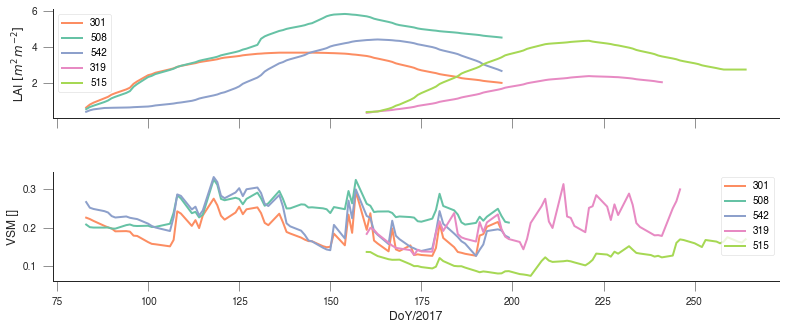

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 5))
l1 = []
l2 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], df[f"LAI_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")


axs[0].set_ylabel(r"LAI $[m^2\,m^{-2}]$")
axs[1].set_ylabel("VSM []")
axs[1].set_xlabel("DoY/2017")

The above plots show clear phenology diffrences between summer and winter crops, and a surprising amount of variation in soil moisture, although the peaks (hypothesising here that these are due to rainfall events) show a lot of commonality. 

Let's plot the backscatter. Broadly speaking, the ratio of VH/VV should follow a trend that might be linked to volumetric scattering, and hence vegetation optical depth, and hence some form of LAI...

/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'DoY/2017')

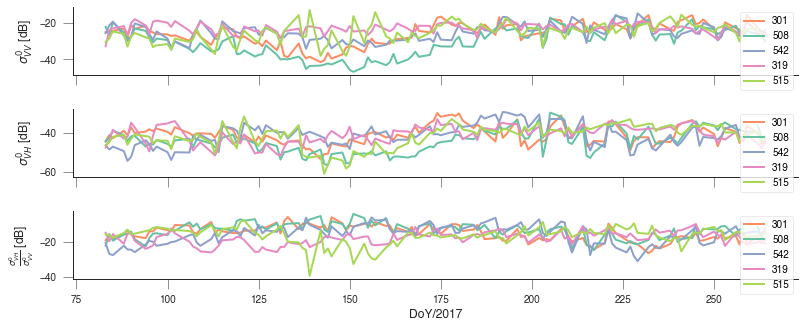

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 5))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], 10*np.log(df[f"sigma_sentinel_vv_{field:s}"]),
                          label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], 10*np.log(df[f"sigma_sentinel_vh_{field:s}"]),
                          label=field))

    l3.append(axs[2].plot(df[f"doy_{field:s}"], 10*np.log(
        df[f"vh/vv_{field:s}"]),
        label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"$\sigma^{0}_{VV}$ [dB]")
axs[1].set_ylabel(r"$\sigma^{0}_{VH}$ [dB]")
axs[2].set_ylabel(r"$\frac{\sigma^{0}_{VH}}{\sigma^{0}_{VV}}$ [dB]")
axs[2].set_xlabel("DoY/2017")

You may need to squint your eyes a bit ;-)

### The Sentinel2 retrieved parameters from KaSKA

We have used KaSKA to retrieve land surface parameters. These are provided on a 20m resolution grid and are reported every 5 days. I have averaged them over each field. Note that this might have actually included some boundary pixels, but hey...

Let's have a look at how things stack up.

(0, 1)

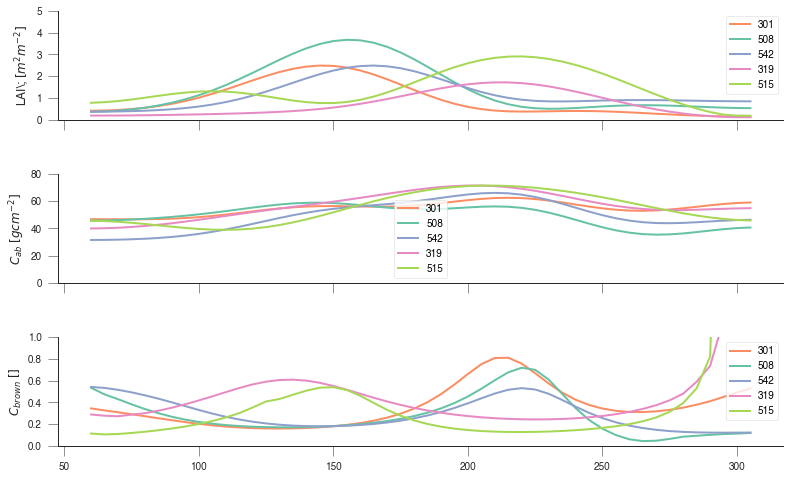

In [6]:
df_s2 = pd.read_csv("LMU_S2_field_retrievals.csv", sep=";")
df_s2['doy'] = pd.to_datetime(df_s2.dates).dt.dayofyear
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 8))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df_s2.doy, df_s2[f"lai_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df_s2.doy, df_s2[f"cab_{field:s}"],
                          label=field))
    l3.append(axs[2].plot(df_s2.doy, df_s2[f"cbrown_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"LAI\; $[m^{2}m^{-2}]$")
axs[1].set_ylabel(r"$C_{ab}\;[gcm^{-2}]$")
axs[2].set_ylabel(r"$C_{brown}\;[]$")
axs[0].set_ylim(0, 5)
axs[1].set_ylim(0, 80)
axs[2].set_ylim(0, 1)

Mostly, LAI appears to be underestimated, and is clearly oversmoothed, but other than that, temporal trends look fairly plausible.

# Inversion strategy

The main assumptions we are making are

* $V_1=V_2=LAI$ This might require further refinement, but basically, $V_i$ are canopy optical thickness
* Assume that there's a strong correlation between $\sigma_{soil}$ in VV and VH polarisations
* If we exploit the S2 LAI data and some uncertainty, we might want to let it float (e.g. update it with the S1 data). There's a risk that we compensate WCM model limitations by changing LAI, so we probably want to keep LAI uncertainty "manageable" (low!)
* We might want to assume smoothness in LAI, but not in soil moisture (it's clearly peaky for rainfall events)
* We don't really have a clue about $A_{pq}$, $B_{pq}$ and $C_{pq}$ parameters. We may have a first guess on $\sigma_{soil}$ when $LAI$ is low, and one could probably make a similar claim for $A\cdot V_1$. 
* The last point is just a trick to get a starting point for the minimisation, but ideally, we'd like to have some form of prior PDF for the WCM parameters.

All this is implemented in a bunch of functions, but the one you may want to look at with more pause is rather unsurprisingly `cost_function`, which bundles everything together. The uncertainty in SAR has been assumed to be 0.5 dB, but that can obviously be changed to deal with changes in speckle filtering and stuff like that.

Let's see how this works for the different fields...

In [15]:

def invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai):
    n_obs = len(svv)
    xvv = np.array([1, 0.5, -.5])
    xvh = np.array([1, 0.5, -.4])
    sm0 = prior_mean[6 : (6 + n_obs)]
    # In reality, this should come from a sensible prior mean, but for the
    # time being...
    x0 = np.concatenate([xvv, xvh, sm0, s2_lai])

    # Put some parameter bounds so we don't end up with crazy numbers
    bounds = (
        [
        [None, None],
        [None, None],
        [-8, 0],
        [None, None],
        [None, None],
        [-8, 0]]       
        + [[-2, 2]] * s2_lai.shape[0]
        + [[0, 8]] * s2_lai.shape[0]
    )
    # Minimise the log-posterior
    retval = scipy.optimize.minimize(
        cost_function,
        x0,
        bounds=bounds,
        jac=True,
        args=(svh, svv, theta, gamma, prior_mean, prior_sd),
        tol=1e-10,
        options={"disp": True},
    )
    print(
        f"Initial cost {cost_function(x0,svh, svv, theta,gamma, prior_mean, prior_sd)[0]:g}"
    )
    print(f"Final cost {retval.fun:g}")
    return retval


/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:102: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:103: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2
/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Initial cost 334755
Final cost 26934.1
[-2.58980337 -0.48070164 -8.         -2.94725017 -0.54709134 -7.99999513]


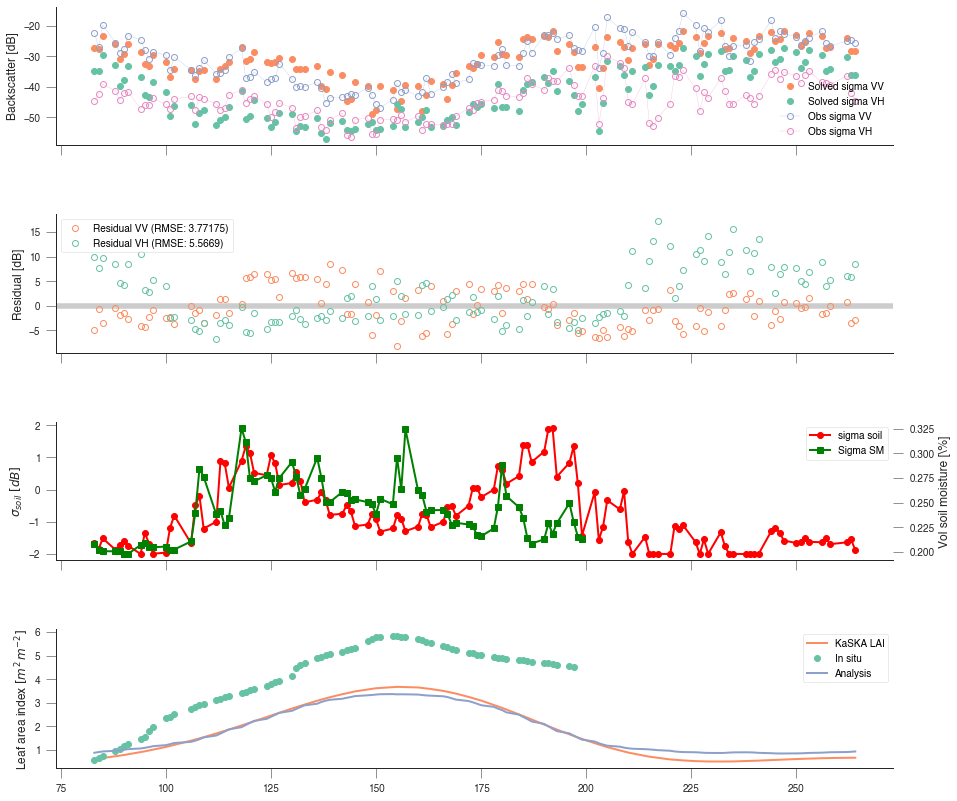

In [23]:
from scipy.ndimage.filters import gaussian_filter1d
field = "508"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
#sm_mean = gaussian_filter1d(sm_mean, 2)
sm_mean = 0.7*np.log10(sm_mean)

#sm_std = 10.*np.nanstd([df[f"SM_{field:s}"][passer]
#                        for field in fields], axis=0)
#sm_std[sm_std>0.5] = 0.5
#sm_std[sm_std == 0] = 0.5
sm_std = np.ones_like(sm_mean)*2.
prior_mean = np.concatenate([[0, ]*6,  sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [.025, ]*n_obs])
gamma = 50000
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)
print(retval.x[:6])

In [8]:
debug

> /home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/ops/roperator.py(25)rtruediv()
     23 
     24 def rtruediv(left, right):
---> 25     return right / left
     26 
     27 



ipdb>  up


> /home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py(70)_evaluate_standard()
     68         _store_test_result(False)
     69     with np.errstate(all="ignore"):
---> 70         return op(a, b)
     71 
     72 



ipdb>  up


> /home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py(126)_evaluate_numexpr()
    124 
    125     if result is None:
--> 126         result = _evaluate_standard(op, op_str, a, b)
    127 
    128     return result



ipdb>  up


> /home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py(220)evaluate()
    218     use_numexpr = use_numexpr and _bool_arith_check(op_str, a, b)
    219     if use_numexpr:
--> 220         return _evaluate(op, op_str, a, b, **eval_kwargs)
    221     return _evaluate_standard(op, op_str, a, b)
    222 



ipdb>  up


> /home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/ops/__init__.py(970)na_op()
    968             result = expressions.evaluate(op, str_rep, x, y, **eval_kwargs)
    969         except TypeError:
--> 970             result = masked_arith_op(x, y, op)
    971 
    972         return missing.dispatch_fill_zeros(op, x, y, result)



ipdb>  up


> /home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/ops/__init__.py(1048)wrapper()
   1046 
   1047         with np.errstate(all="ignore"):
-> 1048             result = na_op(lvalues, rvalues)
   1049         return construct_result(
   1050             left, result, index=left.index, name=res_name, dtype=None



ipdb>  up


> /home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/ops/__init__.py(1743)maybe_dispatch_ufunc_to_dunder_op()
   1741         else:
   1742             name = flipped.get(op_name, "__r{}__".format(op_name))
-> 1743             return getattr(self, name, not_implemented)(inputs[0])
   1744     else:
   1745         return NotImplemented



ipdb>  up


> /home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py(810)__array_ufunc__()
    808         # for binary ops, use our custom dunder methods
    809         result = ops.maybe_dispatch_ufunc_to_dunder_op(
--> 810             self, ufunc, method, *inputs, **kwargs
    811         )
    812         if result is not NotImplemented:



ipdb>  up


> /home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs2.py(31)wcm()
     29         K = K - np.log10(0.095*(0.13 + np.sin(1.5*theta))**1.4)
     30 
---> 31     tau = np.exp(-2 * B * V2 / mu)
     32     veg = A * V1 * (1 - tau)
     33     sigma_soil = K + R + mvs



ipdb>  p B.shape


()


ipdb>  print B


*** SyntaxError: Missing parentheses in call to 'print'. Did you mean print(B)?


ipdb>  p B


0.5


ipdb>  p V2.shape


(119,)


ipdb>  p mu.shape


(120,)


ipdb>  list 20


     15     assumption here is that we only consider first
     16     order effects. The vegetation backscatter contribution
     17     is given by `A*V1`, which is often related to scatterer
     18     (e.g. leaves, stems, ...) properties. The attenuation
     19     due to the canopy is controlled by `B*V2`, which is
     20     often related to canopy moisture content (this is polarisation
     21     and frequency dependent). The soil backscatter is modelled as
     22     using an Oh2004 model.
     23     """
     24     theta = np.deg2rad(theta)
     25     mu = np.cos(theta)



ipdb>  list


     26 
     27     K = np.log10(0.11*(np.cos(theta)**2.2))
     28     if pol.upper() == "VV":
     29         K = K - np.log10(0.095*(0.13 + np.sin(1.5*theta))**1.4)
     30 
---> 31     tau = np.exp(-2 * B * V2 / mu)
     32     veg = A * V1 * (1 - tau)
     33     sigma_soil = K + R + mvs
     34 
     35 
     36     der_dA = V1 - V1 * tau



ipdb>  p V1.shape


(119,)


ipdb>  exit


In [125]:
def oh2004(mv, ks, theta):
    """Oh 2004 soil model as a function of volumetric soil moisture,
    rms height and angle of incidence. 
    Parameters
    ----------
    mv : float, ndarray
        volumetric soil moisture m3/m3
    ks : float
        product of wavenumber and rms height
        be aware that both need to have the same units
    theta : float, ndarray
        incidence angle [rad]
    
    Returns
    -------
    Backscatter (linear units) in HH, VV and HV polarisations

    """
    p1 = (2.0 * theta / np.pi) ** (0.35 * mv ** (-0.65))
    p2 = np.exp(-0.4 * ks ** 1.4)
    p = 1 - p1 * p2
    # p = 1 - (2.*theta/np.pi)**(0.35*mv**(-0.65)) * np.exp(-0.4 * ks**1.4)
    dp_dmv = 0.2275 * p1 * np.log(2.0 * theta / np.pi) * p2 / (mv ** 1.65)
    dp_dks = 0.56 * p1 * np.exp(-0.4 * ks ** 1.4) * ks ** 0.4
    q0 = 0.095 * (0.13 + np.sin(1.5 * theta)) ** 1.4
    q = q0 * (1 - np.exp(-1.3 * ks ** 0.9))
    dq_dmv = 0.0
    dq_dks = q0 * (-1.17 * np.exp(-1.3 * ks ** 0.9) / ks ** 0.1)
    # original a calculations from Oh and jacobian
    # a = 0.11 * mv ** 0.7 * np.cos(theta) ** 2.2
    # da_dmv = 0.7 * 0.11 * np.cos(theta) ** 2.2 / mv ** 0.3
    # da_dks = 0.0
    # Ramp up mv impact to e.g. 2.8
    a = 0.11 * mv ** 2.8 * np.cos(theta) ** 2.2
    da_dmv = 2.8 *(mv ** 1.8)* 0.11 * np.cos(theta) ** 2.2  
    da_dks = 0.0
    b = 1 - np.exp(-0.32 * ks ** 1.8)
    db_mv = 0.0
    db_mks = 0.576 * np.exp(-0.32 * ks ** 1.8) * (ks ** 0.8)

    hv = a * b
    dhv_dmv = da_dmv * b
    dhv_dks = db_mks * a
    vv = a * b / q
    dvv_dmv = (da_dmv * b * q) / (q * q)
    dvv_dks = (db_mks * a * q + dq_dks * a * b) / (q * q)
    hh = hv / q * p

    return [
        [hh, None],
        [vv, np.array([dvv_dmv, dvv_dks])],
        [hv, np.array([dhv_dmv, dhv_dks])],
    ]


passer = s2_lai<1

def cost(x, svv, svh, theta, passer, unc=0.5):
    svv = svv[passer]
    svh = svh[passer]
    theta = theta[passer]
    n_obs = len(svv)
    ks = x[:n_obs]
    mv = x[n_obs:]
    
    [[_,_], 
     [fwd_svv, d_svv], [fwd_svh, d_svh]] = oh2004(mv, ks, np.deg2rad(theta))
    diff_vv = fwd_svv - svv
    diff_vh = fwd_svh - svh
    cost = 0.5*(diff_vv**2 + diff_vh**2)/unc**2
    #jac = diff_vv*d_svv + diff_vh*d_svh
    return cost.sum()#, jac

#svv = np.array(svv.to_list())
#svh = np.array(svh.to_list())
#theta = np.array(theta.to_list())
n_obs = np.sum(passer)
bounds = [[0.01, 10],]*n_obs + [[0.01, 0.5],]*n_obs
x0 = np.concatenate([np.ones(n_obs)*1.5, sm_mean[passer]])
retval = scipy.optimize.minimize(cost, x0, jac=False, args=(svv, svh, theta, passer),
                                 bounds=bounds,
                                options={"disp": True},)
    



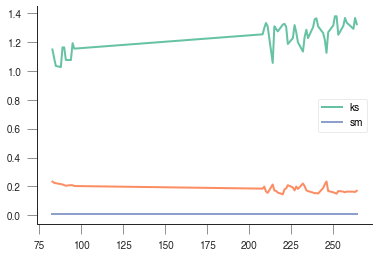

In [126]:
plt.plot(doy[passer], sm_mean[passer])
plt.plot(doy[passer],retval.x[:n_obs], label="ks")
plt.plot(doy[passer],retval.x[n_obs:], label="sm")
plt.legend()

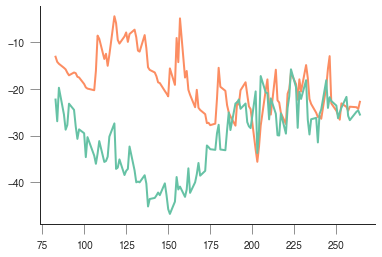

In [119]:
#plt.plot(doy, oh2004(sm_mean, .01, np.deg2rad(30))[2][0])
#plt.plot(doy, 10*np.log10(oh2004(sm_mean, 2.5, np.deg2rad(30))[2][0]))
x= 10*np.log10(oh2004(sm_mean, 1.5, np.deg2rad(30))[2][0])
xx = 10.*(x-x.mean()) + x.mean()
plt.plot(doy, xx)
plt.plot(doy, svv)

Above, the uncertainty in LAI has been set to 0.2, and the amount of smoothing to 50. The prior mean and std dev for soil moisture has been set to the average of all fields and to some ridiculous high uncertainty. The first interesting thing is that within the canopy period (Doy 100 to 175), the results for SM are quite credible. We also see that the SAR data suggests the LAI is might be too late, and reduces it around DoY 160. 

Outside the canopy period, the model does go a bit crazy. We can see that the goodness of fit is worse, and that the parameters are jumping around, so it suggests that other non-modelled effects are at play here.

/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 8474.36
Final cost 2590.33


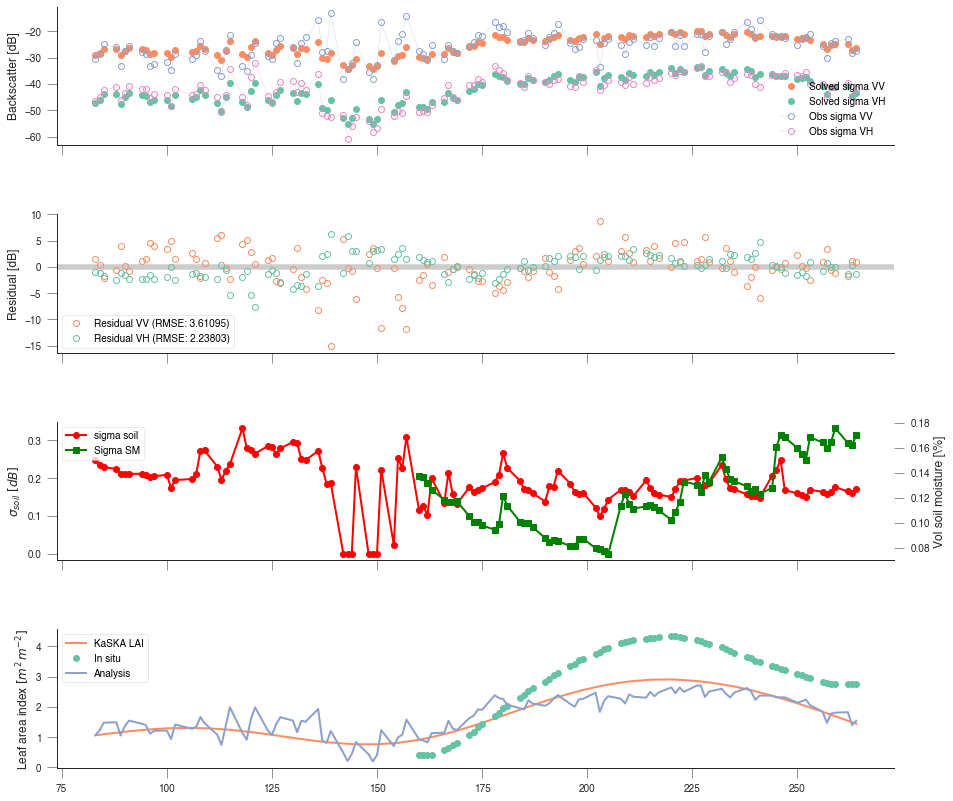

In [9]:
field = "515"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.1, ]*n_obs])
gamma = 10
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

Similar to the previous field, results appear sensible in the vegetation period, but crazy otherwise. We also note that the S2 LAI is  OK in terms of shape, but quite low in absolute value.

/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 5147.96
Final cost 1706.13


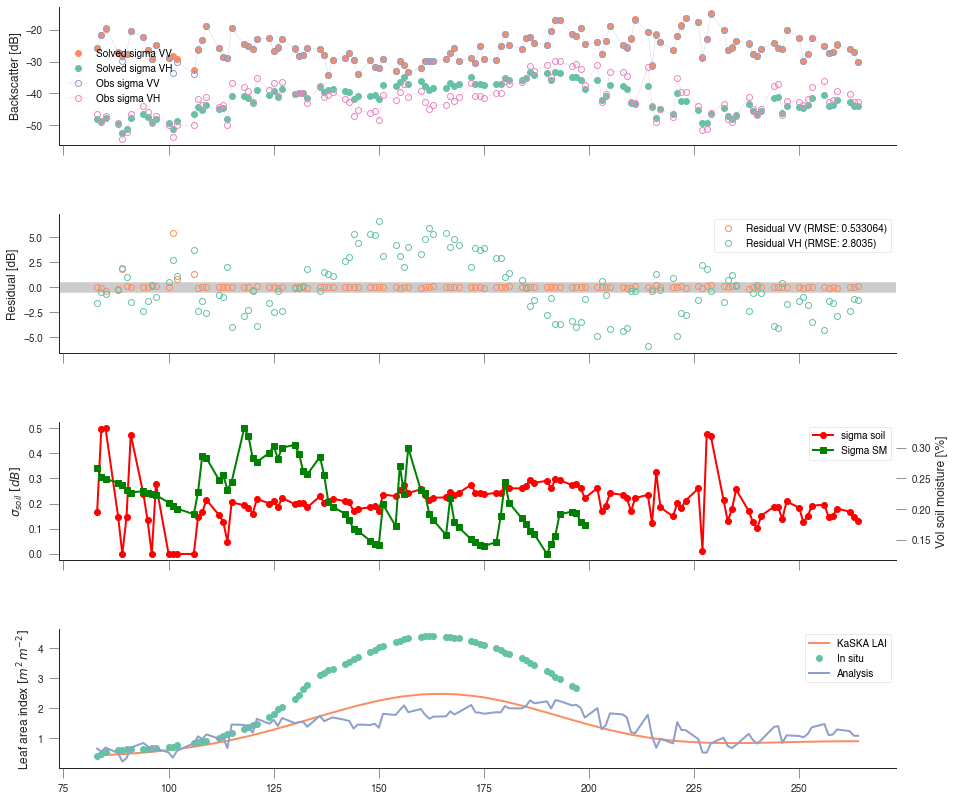

In [10]:
field = "542"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.1, ]*n_obs])
gamma = 5
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

This one takes for ever to minimise, so possibly we can expect some numerical issues at play. This probably explains the poor VH fitting (I mean...). Probably a duffer.

/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 7620.54
Final cost 2343.46


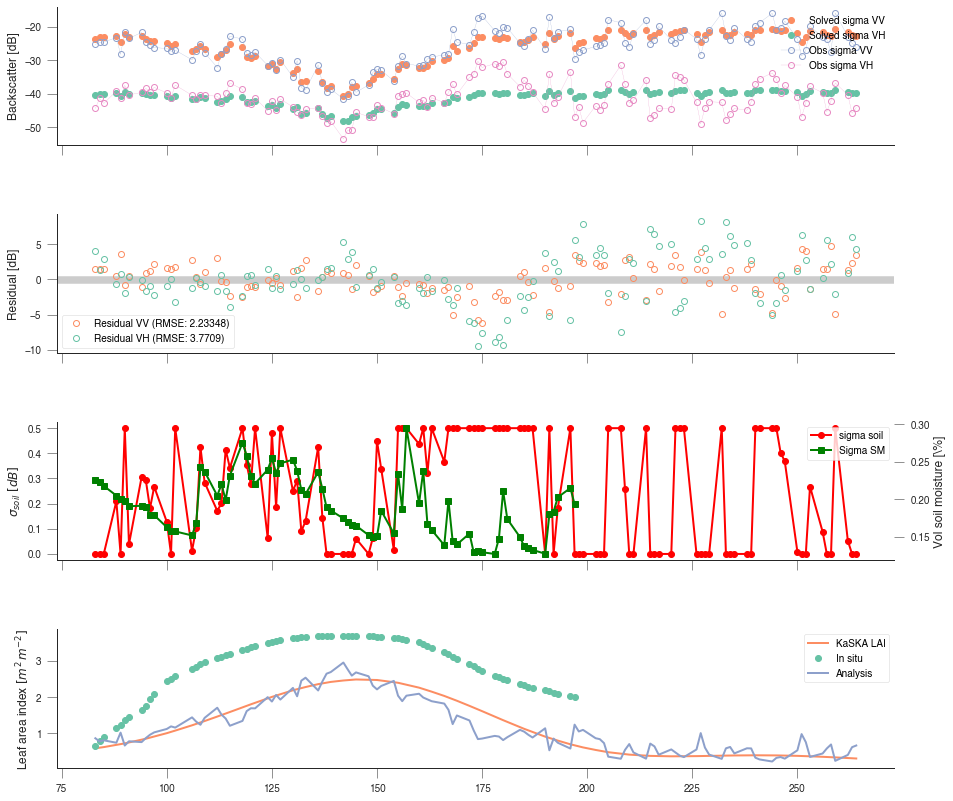

In [11]:
field = "301"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.1, ]*n_obs])
gamma = 10
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

Again, there's some semblance of results when there's a canopy, but for the "fallow" period, the model is incapable to doing anything. Again, we see that the goodness of fit is inversely related to $LAI$, as in the other cases. And actually, it's mostly the VH polarisation that's worse in terms of fitting.

/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 2523.65
Final cost 1323.86


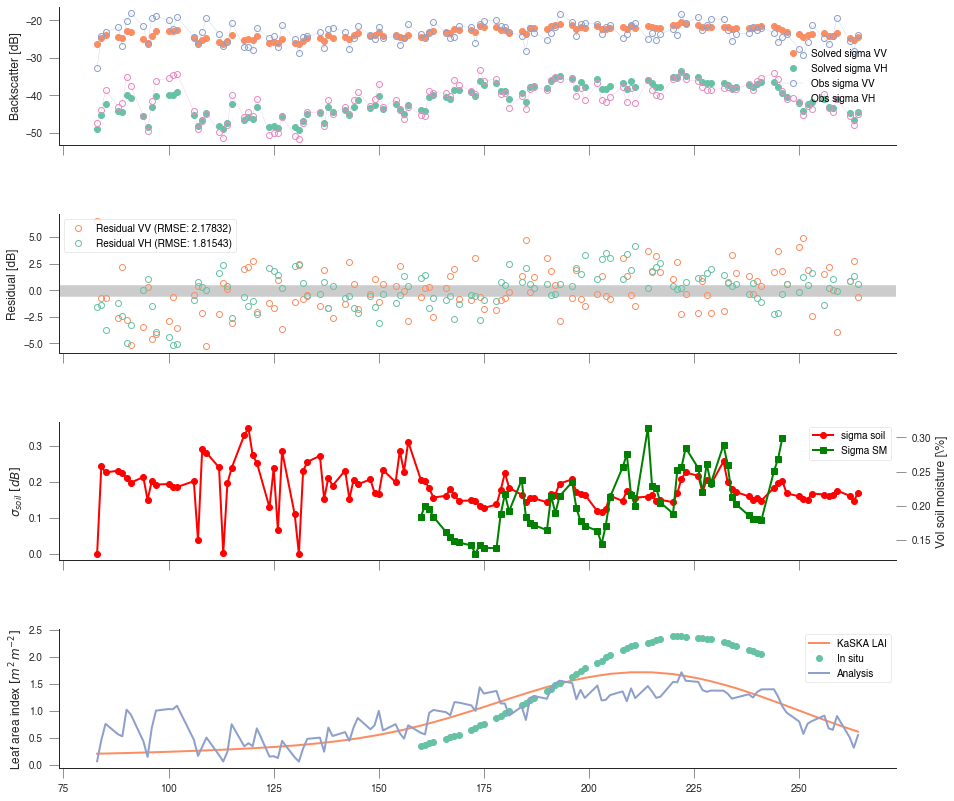

In [12]:
field = "319"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20. * np.nanstd([df[f"SM_{field:s}"][passer] for field in fields],
                         axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.1, ]*n_obs])

gamma = 10
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

Similar comments to above. Note that here the LAI is quite low, and the model underestimates before DoY 175 and tends to overestimate backscatter afterwards. 

So to sum up...
* If you have a canopy, the WCM model with a simple linear relationship between VSM and soil backscatter has some merit.
* However, if there's no canopy, the model appears incapable of coping with observed variations in backscatter and just pushes them to parameters. It appears that this is particularly serious for the VH polarisation, this is probably something that will show up with comparisons with e.g. the Oh models
* Retrieved LAI from optical tends to underestimate the real $LAI$. This might be an artefact of the way it was extracted (there are clear edge effects in the fields), and KaSKA retrievals do appear to be oversmoothed.
* We haven't played with passing funky things to the VOD (e.g. $LAI\cdot C_{ab},\,LAI\cdot C_{brown}, \dots$. Some of this might allow for further finessing of things.
* If we know there's no canopy, we might want to relax the fit to the observations, or possible add different uncertainties to the two polarisations. The justification for this is model error. 


# A new soil under your feet

In [6]:
def oh2004(mv, ks, theta):
    """Oh 2004 soil model as a function of volumetric soil moisture,
    rms height and angle of incidence. 
    Parameters
    ----------
    mv : float, ndarray
        volumetric soil moisture m3/m3
    ks : float
        product of wavenumber and rms height
        be aware that both need to have the same units
    theta : float, ndarray
        incidence angle [rad]
    
    Returns
    -------
    Backscatter (linear units) in HH, VV and HV polarisations

    """
    p = 1 - (2.*theta/np.pi)**(0.35*mv**(-0.65)) * np.exp(-0.4 * ks**1.4)
    q = 0.095 * (0.13 + np.sin(1.5*theta))**1.4 * (1-np.exp(-1.3 * ks**0.9))
    a = 0.11 * mv**0.7 * np.cos(theta)**2.2
    b = 1 - np.exp(-0.32 * ks**1.8)
    hv = a*b
    vv = a*b/q
    hh = hv/q*p
    return hh, vv, hv
    

def wcm(A, V1, B, V2, mv, ks, theta=23, pol="VV"):
    """WCM model with Oh2004 model. The main
    assumption here is that we only consider first
    order effects. The vegetation backscatter contribution
    is given by `A*V1`, which is often related to scatterer
    (e.g. leaves, stems, ...) properties. The attenuation
    due to the canopy is controlled by `B*V2`, which is
    often related to canopy moisture content (this is polarisation
    and frequency dependent). The soil backscatter is modelled as
    using an Oh2004 model.
    """
    mu = np.cos(np.deg2rad(theta))
    tau = np.exp(-2*B*V2/mu)
    veg = A*V1*(1-tau)
    sigma_soil = soil_backscatter(mv, ks, np.deg2rad(theta))
    isel = ["HH", "VV", "HV"].index(pol.upper())
    
    soil = tau*(10*np.log10(sigma_soil[isel]))
    return veg + soil




/home/ucfajlg/python/LMU_SAR_tests/soil_models.py:323: RuntimeWarning: divide by zero encountered in double_scalars
  self.p = 1 - (2.*self.theta/np.pi)**(0.35*self.mv**(-0.65)) * np.exp(-0.4 * self.ks**1.4)
/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'VH')

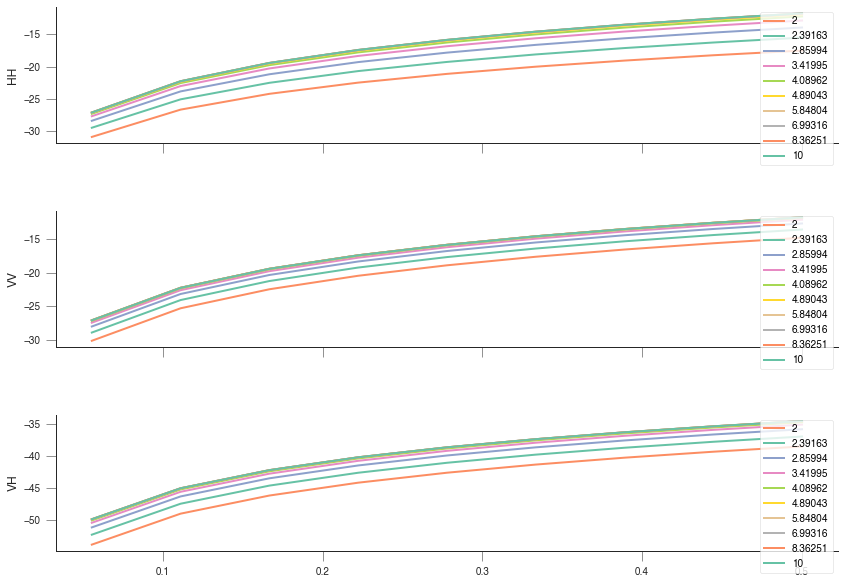

In [76]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, squeeze=True,
                       figsize=(14,10))
axs = axs.flatten()
for ks in np.logspace(np.log10(2), np.log10(10.), 10):
    shh = [] ; svv = [] ; svh = []
    
    for sm in np.linspace(0, 0.5, 10):
        sigmas = soil_backscatter(sm, ks, np.deg2rad(45))
        shh.append(sigmas[0])
        svv.append(sigmas[1])
        svh.append(sigmas[2])
    axs[0].plot(np.linspace(0, 0.5, 10), 10*np.log(shh), '-', label="%g"%ks)
    axs[1].plot(np.linspace(0, 0.5, 10), 10*np.log(svv), '-', label="%g"%ks)
    axs[2].plot(np.linspace(0, 0.5, 10), 10*np.log(svh), '-', label="%g"%ks)
axs[0].legend(loc="best")
axs[1].legend(loc="best")
axs[2].legend(loc="best")
axs[0].set_ylabel("HH")
axs[1].set_ylabel("VV")
axs[2].set_ylabel("VH")
    

In [7]:
field = "508"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.2, ]*n_obs])
gamma = 50
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)


/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 18727.1
Final cost 1944.85


/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/ucfajlg/python/LMU_SAR_tests/soil_models.py:323: RuntimeWarning: divide by zero encountered in power
  self.p = 1 - (2.*self.theta/np.pi)**(0.35*self.mv**(-0.65)) * np.exp(-0.4 * self.ks**1.4)
/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10


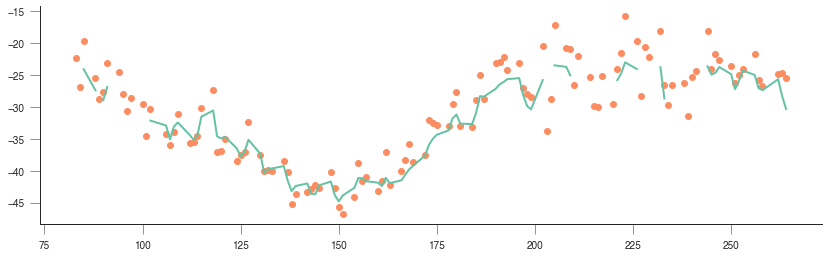

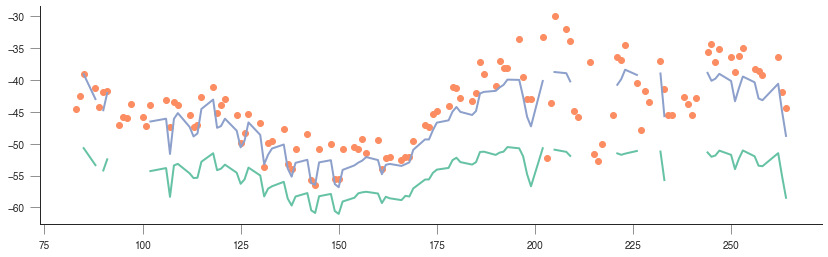

In [88]:
n_obs = len(svv)
A_vv, B_vv, C_vv, A_vh, B_vh, C_vh = retval.x[:6]
vsm = retval.x[6 : (6 + n_obs)]
lai = retval.x[(6 + n_obs) :]


plt.figure(figsize=(14,4))
plt.plot(doy, svv, 'o')
k = 50
sim_vv = wcm(A_vv, lai, B_vv, lai, C_vv, vsm, k, theta=np.array(theta.to_list()), pol="VV")
plt.plot(doy, sim_vv, '-')
plt.figure(figsize=(14,4))
plt.plot(doy, svh, 'o')
k = 100
sim_vh = wcm(A_vh, lai, B_vh, lai, C_vh, vsm, k, theta=np.array(theta.to_list()), pol="HV")
plt.plot(doy, sim_vh, '-')

k = 50
sim_vh = wcm(A_vh, lai, B_vh, lai, C_vh, 100*vsm, k, theta=np.array(theta.to_list()), pol="HV")
plt.plot(doy, sim_vh, '-')

In [32]:
def oh2004(mv, ks, theta):
    """Oh 2004 soil model as a function of volumetric soil moisture,
    rms height and angle of incidence. 
    Parameters
    ----------
    mv : float, ndarray
        volumetric soil moisture m3/m3
    ks : float
        product of wavenumber and rms height
        be aware that both need to have the same units
    theta : float, ndarray
        incidence angle [rad]
    
    Returns
    -------
    Backscatter (linear units) in HH, VV and HV polarisations

    """
    p = 1 - (2.*theta/np.pi)**(0.35*mv**(-0.65)) * np.exp(-0.4 * ks**1.4)
    q = 0.095 * (0.13 + np.sin(1.5*theta))**1.4 * (1-np.exp(-1.3 * ks**0.9))
    a = 0.11 * mv**0.7 * np.cos(theta)**2.2
    b = 1 - np.exp(-0.32 * ks**1.8)
    hv = a*b
    vv = a*b/q
    hh = hv/q*p
    return hh, vv, hv
    

def wcm(A, V1, B, V2, mv, ks, theta=23, pol="VV"):
    """WCM model with Oh2004 model. The main
    assumption here is that we only consider first
    order effects. The vegetation backscatter contribution
    is given by `A*V1`, which is often related to scatterer
    (e.g. leaves, stems, ...) properties. The attenuation
    due to the canopy is controlled by `B*V2`, which is
    often related to canopy moisture content (this is polarisation
    and frequency dependent). The soil backscatter is modelled as
    using an Oh2004 model.
    """
    mu = np.cos(np.deg2rad(theta))
    tau = np.exp(-2*B*V2/mu)
    veg = A*V1*(1-tau)
    sigma_soil = soil_backscatter(mv, ks, np.deg2rad(theta))
    isel = ["HH", "VV", "HV"].index(pol.upper())
    soil = tau*sigma_soil[isel]
    return veg + soil


def cost_obs(x, svh, svv, theta, unc=0.5):
    """Cost function. Order of parameters is
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh,
    vsm_0, ..., vsm_N,
    LAI_0, ..., LAI_N
    
    We assume that len(svh) == N
    Uncertainty is the uncertainty in backscatter, and
    assume that there are two polarisations (VV and VH),
    although these are just labels!
    """
    n_obs = svh.shape[0]
    A_vv, B_vv, A_vh, B_vh, ks = x[:5]
    vsm = x[5 : (5 + n_obs)]
    lai = x[(5 + n_obs) :]
    sigma_vv = wcm(A_vv, lai, B_vv, lai, vsm, ks, theta=theta, pol="VV")
    sigma_vh = wcm(A_vv, lai, B_vv, lai, vsm, ks, theta=theta, pol="HV")
    diff_vv = svv - sigma_vv
    diff_vh = svh - sigma_vh
    cost = 0.5 * (diff_vv ** 2 + diff_vh ** 2) / (unc ** 2)
    return cost.sum()#, -jac / (unc ** 2)


def cost_prior(x, svh, svv, theta, prior_mean, prior_unc):
    """A Gaussian cost function prior. We assume no correlations
    between parameters, only mean and standard deviation.
    Cost function. Order of parameters is
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh,
    vsm_0, ..., vsm_N,
    LAI_0, ..., LAI_N
    
    We assume that len(svh) == N
    """
    n_obs = len(svh)
    prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
    dprior_cost = -(prior_mean - x) / prior_unc ** 2
    dprior_cost[:6] = 0.0
    return (prior_cost[6:]).sum()#, dprior_cost


def cost_smooth(x, gamma):
    """A smoother for one parameter (e.g. LAI or whatever).
    `gamma` controls the magnitude of the smoothing (higher
    `gamma`, more smoothing)
    """
    # Calculate differences
    p_diff1 = x[1:-1] - x[2:]
    p_diff2 = x[1:-1] - x[:-2]
    # Cost function
    xcost_model = 0.5 * gamma * np.sum(p_diff1 ** 2 + p_diff2 ** 2)
    # Jacobian
    xdcost_model = 1 * gamma * (p_diff1 + p_diff2)
    # Note that we miss the first and last elements of the Jacobian
    # They're zero!
    return xcost_model#, xdcost_model


def cost_function(x, svh, svv, theta, gamma, prior_mean, prior_unc, unc=0.8):
    """A combined cost function that calls the prior, fit to the observations
    """
    # Fit to the observations
    cost1 = cost_obs(x, svh, svv, theta, unc=unc)
    # Fit to the prior
    cost2 = cost_prior(x, svh, svv, theta, prior_mean, prior_unc)
    # Smooth evolution of LAI
    n_obs = len(svv)
    lai = x[(6 + n_obs) :]
    cost3 = cost_smooth(lai, gamma)
    #tmp = np.zeros_like(dcost1)
    #tmp[(7 + n_obs) : -1] = dcost3
    return cost1 + cost2 + cost3#, dcost1 + dcost2 + tmp


field = "508"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*5, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*5, sm_std, [0.2, ]*n_obs])
gamma = 150


n_obs = len(svv)
# Do some dodgy starting point guessing
# In reality, this should come from a sensible prior mean, but for the
# time being...
sm0 = prior_mean[5 : (5 + n_obs)]
A_vv0, B_vv0, A_vh0, B_vh0, ks = -20, 0.5, -20, 0.5,  4.
x0 = np.concatenate([np.array([A_vv0, B_vv0, A_vh0, B_vh0, ks]), sm0, s2_lai])
print(sm0.shape, prior_mean.shape, x0.shape)
# Put some parameter bounds so we don't end up with crazy numbers
bounds = (
        [[None, None]] * 5
        + [[0, 0.5]] * s2_lai.shape[0]
        + [[0, 8]] * s2_lai.shape[0]
    )
# Minimise the log-posterior
retval = scipy.optimize.minimize(
        cost_function,
        x0,
        bounds=bounds,
        args=(svh, svv, theta, gamma, prior_mean, prior_sd),
        tol=1e-10,
        options={"disp": True},
    )
print(
        f"Initial cost {cost_function(x0,svh, svv, theta,gamma, prior_mean, prior_sd):g}"
    )
print(f"Final cost {retval.fun:g}")

/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide


(120,) (245,) (245,)


/home/ucfajlg/python/LMU_SAR_tests/soil_models.py:323: RuntimeWarning: divide by zero encountered in power
  self.p = 1 - (2.*self.theta/np.pi)**(0.35*self.mv**(-0.65)) * np.exp(-0.4 * self.ks**1.4)


Initial cost 91752.2
Final cost 11070.6


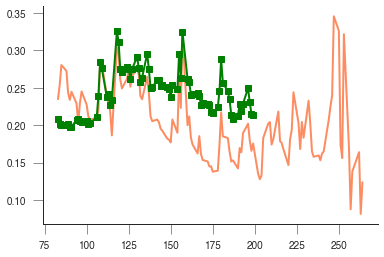

In [33]:
plt.plot(doy,retval.x[5:(5+n_obs)])
plt.plot(
        df[f"doy_{field:s}"], df[f"SM_{field:s}"], "s-g")


In [34]:
retval.x[:6]

array([-21.36639504,   0.76399046, -20.        ,   0.5       ,
         4.00436421,   0.23514145])